# Machine and Deep Learning exploration of Fashion-MNIST dataset

### Simone De Renzis
simone.derenzis@studenti.unipd.it



The aim of this report is to assess the performance of various classical Machine and Deep learning algorithms on the Fashion-MNIST dataset. Starting from basic models and arriving to the more complex ones, every algorithm is tuned with a hyperparameters grid search in order to get a suitable optimal model to compare with the others. To do this, a first exaustive grid search is performed on PCA compressed data, in order to estimate in a faster way a subset of hyperparameters for every model: from these, another search is performed, this time on full resolution data, to obtain the best models. Moreover, different preprocessing and data augmentation techniques are explored to see if the performance can be improved. 

Note: this notebook has been prepared and run on Google Colab with Python 3.7 and Tensorflow 2.7.0. Different configuration might lead to different results.

## Imports
General libraries and utilities are imported here.

In [1]:
# libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# utilites
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical 
from keras.utils.vis_utils import plot_model
from sklearn.metrics import f1_score

## Dataset

In [2]:
# Import the dataset
(X_train_val, y_train_val), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# it's in 28x28 format, so I flatten it
X_train_val = np.reshape(X_train_val,(60000,784))
X_test = np.reshape(X_test,(10000,784))

# Define a dictionary to map the numeric representation to the string
labels_dict = {
    0 :	"T-shirt/top",
    1 :	"Trouser",
    2 :	"Pullover",
    3 :	"Dress",
    4 :	"Coat",
    5 :	"Sandal",
    6 :	"Shirt",
    7 :	"Sneaker",
    8 :	"Bag",
    9 :	"Ankle boot"
}

4431872/4422102 [==============================] - 0s 0us/step


Scaling each pixel value in [0,1]

In [3]:
X_train_val_sc = X_train_val/255
X_test_sc = X_test/255

Visualize a sample of the images of the training set

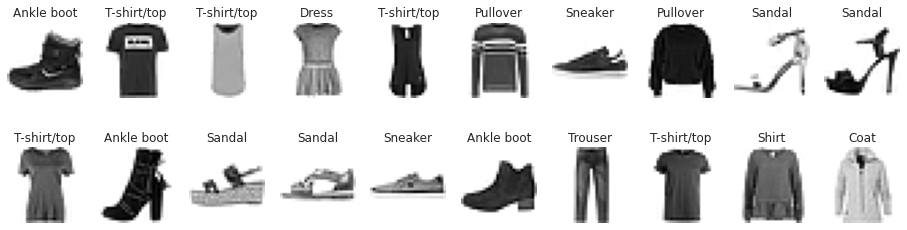

In [ ]:
def add_subplot_border(ax, width=0, color=None):
    fig = ax.get_figure()

    # Convert bottom-left and top-right to display coordinates
    x0, y0 = ax.transAxes.transform((0, 0))
    x1, y1 = ax.transAxes.transform((1, 1))

    # Adjust margins
    x0 -= width
    x1 += width
    y0 -= width
    y1 += width

    # Convert back to Axes coordinates
    x0, y0 = ax.transAxes.inverted().transform((x0, y0))
    x1, y1 = ax.transAxes.inverted().transform((x1, y1))

    rect = plt.Rectangle((x0, y0), x1-x0, y1-y0,
                         color=color,
                         transform=ax.transAxes,
                         zorder=-1)

    fig.patches.append(rect)


def print_samples(X,num_row,num_col,labels_dict=None,y=None,y_pred=None,titles=None):
  fig, axes = plt.subplots(num_row, num_col, figsize=(1.6*num_col,2.1*num_row))
  for i in range(num_row * num_col):
      ax = axes[i//num_col, i%num_col]
      ax.set_axis_off()
      ax.imshow(X[i].reshape((28,28)), cmap='gray_r')
      # custom titles for every image
      if titles is not None:
        ax.set_title(titles[i])
      # if there are labels, use them as title
      if y is not None:
        # if there are no prediction, simply plot the sample
        if y_pred is None:
          ax.set_title(labels_dict[y[i]])
        # otherwise, every sample image is contoured with a colored frame
        else:
          ax.set_title("True: " + labels_dict[y[i]] + "\nPred: " + labels_dict[y_pred[i]])
          if y[i] == y_pred[i]:
            add_subplot_border(ax,3,'g')
          else:
            add_subplot_border(ax,3,'r')
  plt.show()

# plot 2 rows of 10 samples each
print_samples(X_train_val,2,10,labels_dict,y=y_train_val)

### UMAP visualization

I use UMAP to project the dataset in 2d. Reference [here](https://umap-learn.readthedocs.io/en/latest/).

In [ ]:
!pip install umap-learn
import umap

     |████████████████████████████████| 86 kB 3.3 MB/s 
     |████████████████████████████████| 1.1 MB 34.4 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=c65c1a21e652605cf630e58d36df94eb5afaafc35085ab1098bd505e25c5588e
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=9a23509199cbe965272629b4d05f219a59939fe7f17fbf3ae7205ce8fc708aa5
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent


In [ ]:
# reduce to 2 dimensions
reduced_res = umap.UMAP(n_neighbors=50,n_components=2).fit_transform(X_train_val)

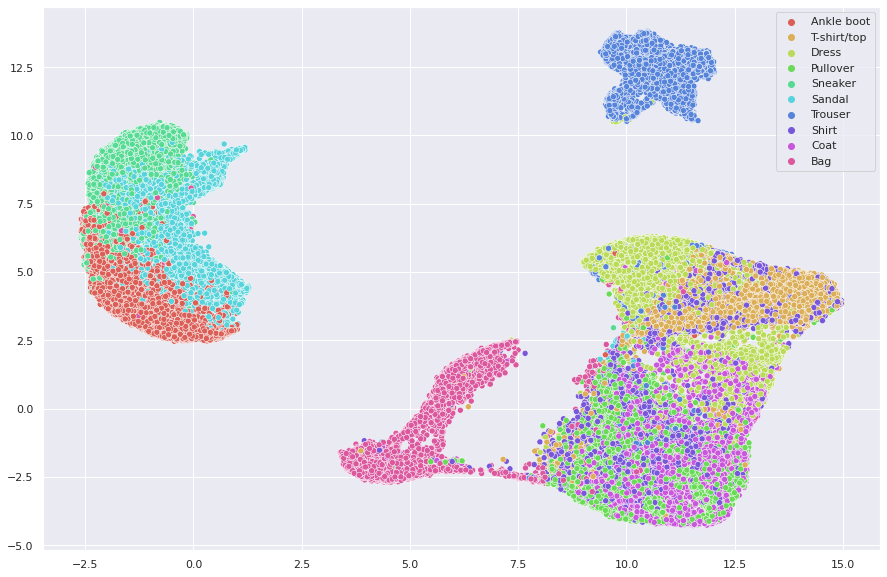

In [ ]:
sns.set(rc={'figure.figsize':(15,10)})
sns.scatterplot(x = reduced_res[:,0], y = reduced_res[:,1], hue = [labels_dict[k] for k in y_train_val], palette = sns.hls_palette(10), legend = 'full')

## Training

I define a general function that performs training and evaluation on a given model and with a given set of grid search hyperparameters.

In [4]:
import graphviz 
import sys
import pandas as pd
from IPython.display import display, HTML
from sklearn.model_selection import GridSearchCV


def model_train_evaluate(model,grid_params,X_train_val,y_train_val):
  # train
  print("Training...")
  model_v1 = GridSearchCV(model, grid_params, n_jobs= -1, cv = 5, return_train_score = True)
  model_v1.fit(X_train_val, y_train_val)
 
  # models comparison: prints a nice table with a comparison between different hyperparameters
  # configurations. Note: if you can't see the table, open this file with Google Colab
  results = pd.DataFrame(model_v1.cv_results_)
  results = results.sort_values(by=["rank_test_score"])
  results = results[["params", "rank_test_score","mean_train_score","mean_test_score"]]
  display(HTML(results.to_html()))

  # evaluate
  print("Evaluating...")  
  y_train_val_pred = model_v1.predict(X_train_val)

  # print results
  model_name = model.__class__.__name__
  print(f"{model_name}\tTrain_val: {f1_score(y_train_val, y_train_val_pred,average = 'macro'):.4f}")
  print(f"\tBest parameters: {model_v1.best_params_}")

  # returns the best model
  best_model = {
      'model' : model_v1.best_estimator_,
      'y_train_val_pred' : y_train_val_pred,
  }
  return best_model


### Exhaustive grid search with PCA reduced images and sampled

Grid search is an expensive procedure. To reduce its computational cost, I perform it on a subset of the original dataset (2'000 images per class, for a total of 20'000 out of 60'000) and I reduce the dimensionality of every image from 784 (28x28) to 50.

In [ ]:
import random
from sklearn.decomposition import PCA

# sample "n_sampled" examples from each of the "n_classes" classes
def sample_n_elements_from_each_class(X,y,n_sampled,tot_elements,n_classes):
  positions = np.arange(tot_elements)
  accumulator = []
  for i in range(n_classes):
    # extract the positions of the samples of the i-th class,
    position_masks = positions[y == i]
    # randomly sample only a part of them (n_examples_for_class)
    sampler = random.sample(range(len(position_masks)), n_sampled)
    # accumulate them in a global vector that holds the sampled positions of
    # all the classes
    accumulator = np.hstack((accumulator,position_masks[sampler]))

  # take the actual samples from the positions
  X_sampled = np.take(X, accumulator.astype("int"), axis=0)
  y_sampled = np.take(y, accumulator.astype("int"))

  # shuffle the vectors in the same way
  np.random.seed(123)
  np.random.shuffle(X_sampled)
  np.random.seed(123)
  np.random.shuffle(y_sampled)

  # return
  return X_sampled,y_sampled


# compress the dataset "X" into "n_components" dimensions
def pca_compress(X,n_components):
  pca = PCA(n_components=n_components)
  X_pca = pca.fit_transform(X)
  X_reconstruced = pca.inverse_transform(X_pca)
  return X_pca, X_reconstruced


In [ ]:
# sample 2000 elements from each of the 10 classes: total 20000 elements
X_train_val_sampled,y_train_val_sampled = sample_n_elements_from_each_class(X_train_val_sc,y_train_val,2000,60000,10)

# PCA to 50 dimensions
X_train_val_sampled_pca, X_train_pca_reconstructed = pca_compress(X_train_val_sampled,50)

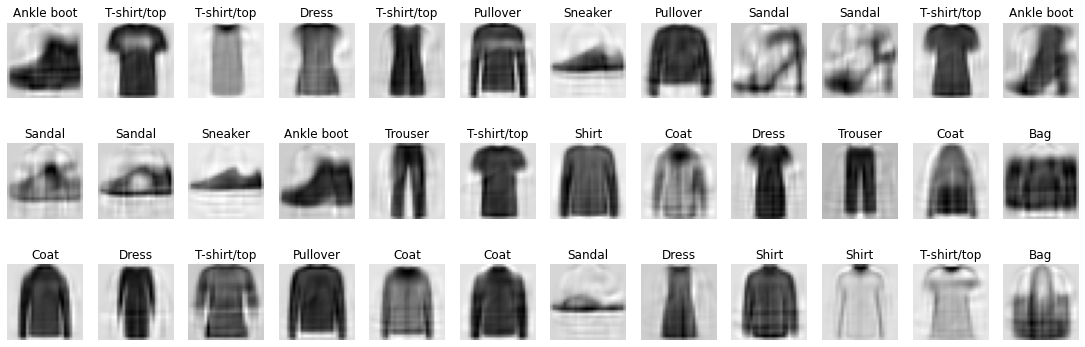

In [ ]:
print_samples(X_train_pca_reconstructed,3,12,labels_dict,y_train_val_sampled)

In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# train the decision tree
dt_grid_params = {
    'criterion': ['gini','entropy'],
    'max_depth': (None, 5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25),
}

dt_clf = DecisionTreeClassifier(random_state= 123)
dt_trained = model_train_evaluate(dt_clf,dt_grid_params,X_train_val_sampled_pca,y_train_val_sampled)

Training...


,params,rank_test_score,mean_train_score,mean_test_score
26,"{'criterion': 'entropy', 'max_depth': 12}",1,0.904375,0.772000
27,"{'criterion': 'entropy', 'max_depth': 13}",2,0.930183,0.771433
25,"{'criterion': 'entropy', 'max_depth': 11}",3,0.874792,0.771233
24,"{'criterion': 'entropy', 'max_depth': 10}",4,0.845800,0.770700
10,"{'criterion': 'gini', 'max_depth': 14}",5,0.910358,0.769067
9,"{'criterion': 'gini', 'max_depth': 13}",6,0.887100,0.766233
11,"{'criterion': 'gini', 'max_depth': 15}",7,0.931150,0.765567
28,"{'criterion': 'entropy', 'max_depth': 14}",8,0.953783,0.765300
23,"{'criterion': 'entropy', 'max_depth': 9}",9,0.817483,0.764133
8,"{'criterion': 'gini', 'max_depth': 12}",10,0.862642,0.764000


Evaluating...
DecisionTreeClassifier	Train_val: 0.8943
	Best parameters: {'criterion': 'entropy', 'max_depth': 12}


In [ ]:
from sklearn.linear_model import Perceptron

# train the perceptron
pc_grid_params = {
    'fit_intercept': [True,False],
    'penalty': [None, 'l2', 'l1'],
    'alpha' : [0.0001,0.00001,0.000001],
    'shuffle': [True, False]
}

pc_clf = Perceptron(random_state= 123)
pc_trained = model_train_evaluate(pc_clf,pc_grid_params,X_train_val_sampled_pca,y_train_val_sampled)

Training...


,params,rank_test_score,mean_train_score,mean_test_score
16,"{'alpha': 1e-05, 'fit_intercept': True, 'penalty': 'l1', 'shuffle': True}",1,0.778875,0.777233
28,"{'alpha': 1e-06, 'fit_intercept': True, 'penalty': 'l1', 'shuffle': True}",2,0.774783,0.772200
14,"{'alpha': 1e-05, 'fit_intercept': True, 'penalty': 'l2', 'shuffle': True}",3,0.771558,0.768600
26,"{'alpha': 1e-06, 'fit_intercept': True, 'penalty': 'l2', 'shuffle': True}",4,0.765317,0.762667
1,"{'alpha': 0.0001, 'fit_intercept': True, 'penalty': None, 'shuffle': False}",5,0.764183,0.761233
25,"{'alpha': 1e-06, 'fit_intercept': True, 'penalty': None, 'shuffle': False}",5,0.764183,0.761233
13,"{'alpha': 1e-05, 'fit_intercept': True, 'penalty': None, 'shuffle': False}",5,0.764183,0.761233
4,"{'alpha': 0.0001, 'fit_intercept': True, 'penalty': 'l1', 'shuffle': True}",8,0.752600,0.751067
29,"{'alpha': 1e-06, 'fit_intercept': True, 'penalty': 'l1', 'shuffle': False}",9,0.751558,0.748367
17,"{'alpha': 1e-05, 'fit_intercept': True, 'penalty': 'l1', 'shuffle': False}",10,0.752958,0.748000


Evaluating...
Perceptron	Train_val: 0.7693
	Best parameters: {'alpha': 1e-05, 'fit_intercept': True, 'penalty': 'l1', 'shuffle': True}


In [ ]:
from sklearn.linear_model import LogisticRegression

# train the logistic regression model
lr_grid_params = {
    'fit_intercept': [True,False],
    'C': [0.001, 0.01, 0.1, 1, 10, 20]
}

lr_clf = LogisticRegression(random_state= 123,max_iter=10000)
lr_trained = model_train_evaluate(lr_clf,lr_grid_params,X_train_val_sampled_pca,y_train_val_sampled)

Training...


,params,rank_test_score,mean_train_score,mean_test_score
8,"{'C': 10, 'fit_intercept': True}",1,0.843642,0.837833
10,"{'C': 20, 'fit_intercept': True}",2,0.843717,0.837767
6,"{'C': 1, 'fit_intercept': True}",3,0.842592,0.837300
4,"{'C': 0.1, 'fit_intercept': True}",4,0.838325,0.834067
9,"{'C': 10, 'fit_intercept': False}",5,0.838433,0.833500
11,"{'C': 20, 'fit_intercept': False}",6,0.838442,0.833433
7,"{'C': 1, 'fit_intercept': False}",7,0.838175,0.833233
5,"{'C': 0.1, 'fit_intercept': False}",8,0.835883,0.831200
2,"{'C': 0.01, 'fit_intercept': True}",9,0.826200,0.823100
3,"{'C': 0.01, 'fit_intercept': False}",10,0.825367,0.822533


Evaluating...
LogisticRegression	Train_val: 0.8426
	Best parameters: {'C': 10, 'fit_intercept': True}


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# train the random forest
rf_grid_params = {
    'n_estimators': (15, 20, 30, 40, 50),
    'criterion': ['entropy'],
    'max_depth': (None, 5, 10, 20, 30),
}
rf_clf = RandomForestClassifier(random_state= 123)
rf_trained = model_train_evaluate(rf_clf,rf_grid_params,X_train_val_sampled_pca,y_train_val_sampled)

Training...


,params,rank_test_score,mean_train_score,mean_test_score
19,"{'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 50}",1,0.999508,0.880433
4,"{'criterion': 'entropy', 'max_depth': None, 'n_estimators': 50}",2,0.999958,0.880267
24,"{'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 50}",3,0.999958,0.880250
18,"{'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 40}",4,0.999354,0.879367
3,"{'criterion': 'entropy', 'max_depth': None, 'n_estimators': 40}",5,0.999896,0.879200
23,"{'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 40}",6,0.999896,0.879083
2,"{'criterion': 'entropy', 'max_depth': None, 'n_estimators': 30}",7,0.999783,0.878150
22,"{'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 30}",8,0.999783,0.878117
17,"{'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 30}",9,0.999046,0.877017
1,"{'criterion': 'entropy', 'max_depth': None, 'n_estimators': 20}",10,0.999083,0.872783


Evaluating...
RandomForestClassifier	Train_val: 0.9994
	Best parameters: {'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 50}


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# train the K-NN
knn_grid_params = {
    'n_neighbors': (2,5,7,10,20,25,30,50)
}
knn_clf = KNeighborsClassifier()
knn_trained = model_train_evaluate(knn_clf,knn_grid_params,X_train_val_sampled_pca,y_train_val_sampled)

Training...


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


,params,rank_test_score,mean_train_score,mean_test_score
2,{'n_neighbors': 7},1,0.890483,0.859650
3,{'n_neighbors': 10},2,0.882517,0.859333
1,{'n_neighbors': 5},3,0.900262,0.859083
4,{'n_neighbors': 20},4,0.866742,0.855150
5,{'n_neighbors': 25},5,0.862342,0.852683
6,{'n_neighbors': 30},6,0.859321,0.850400
7,{'n_neighbors': 50},7,0.849029,0.843950
0,{'n_neighbors': 2},8,0.926775,0.842083


Evaluating...
KNeighborsClassifier	Train_val: 0.8921
	Best parameters: {'n_neighbors': 7}


In [ ]:
from sklearn.svm import SVC

# train the svc
svc_grid_params = {
    'C': [1,0.1,0.01,0.001],
    'kernel': ['rbf','linear'],
}

svc_clf = SVC(random_state= 123)
svc_trained = model_train_evaluate(svc_clf,svc_grid_params,X_train_val_sampled_pca,y_train_val_sampled)

Training...


,params,rank_test_score,mean_train_score,mean_test_score
0,"{'C': 1, 'kernel': 'rbf'}",1,0.895279,0.881600
1,"{'C': 1, 'kernel': 'linear'}",2,0.857013,0.852033
3,"{'C': 0.1, 'kernel': 'linear'}",3,0.855538,0.851267
2,"{'C': 0.1, 'kernel': 'rbf'}",4,0.851796,0.847700
5,"{'C': 0.01, 'kernel': 'linear'}",5,0.847321,0.844750
7,"{'C': 0.001, 'kernel': 'linear'}",6,0.819179,0.817883
4,"{'C': 0.01, 'kernel': 'rbf'}",7,0.786250,0.785233
6,"{'C': 0.001, 'kernel': 'rbf'}",8,0.710171,0.709350


Evaluating...
SVC	Train_val: 0.8962
	Best parameters: {'C': 1, 'kernel': 'rbf'}


### Grid search on full resolution data

Grid search on PCA compressed data helped to obtain a restricted range in which the hyperparameters take value. I will now use this to perform a second grid search, this time on full resolution data.

In [ ]:
# train the perceptron
pc1_grid_params = {
    'fit_intercept': [True],
    'penalty': ['l2', 'l1'],
    'alpha' : [1e-05,1e-06,1e-07],
    'shuffle': [True]
}

pc1_clf = Perceptron(random_state= 123)
pc1_trained = model_train_evaluate(pc1_clf,pc1_grid_params,X_train_val_sc,y_train_val)

Training...


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


,params,rank_test_score,mean_train_score,mean_test_score
2,"{'alpha': 1e-06, 'fit_intercept': True, 'penalty': 'l2', 'shuffle': True}",1,0.826137,0.811617
1,"{'alpha': 1e-05, 'fit_intercept': True, 'penalty': 'l1', 'shuffle': True}",2,0.819575,0.802117
3,"{'alpha': 1e-06, 'fit_intercept': True, 'penalty': 'l1', 'shuffle': True}",3,0.814754,0.797700
4,"{'alpha': 1e-07, 'fit_intercept': True, 'penalty': 'l2', 'shuffle': True}",4,0.814642,0.797400
5,"{'alpha': 1e-07, 'fit_intercept': True, 'penalty': 'l1', 'shuffle': True}",5,0.808700,0.793083
0,"{'alpha': 1e-05, 'fit_intercept': True, 'penalty': 'l2', 'shuffle': True}",6,0.782963,0.776467


Evaluating...
Perceptron	Train_val: 0.8265
	Best parameters: {'alpha': 1e-06, 'fit_intercept': True, 'penalty': 'l2', 'shuffle': True}


In [ ]:
# train the decision tree
dt1_grid_params = {
    'criterion': ['gini','entropy'],
    'max_depth': (None, 11,12,13,14,15),
}

dt1_clf = DecisionTreeClassifier(random_state= 123)
dt1_trained = model_train_evaluate(dt1_clf,dt1_grid_params,X_train_val_sc,y_train_val)

Training...


,params,rank_test_score,mean_train_score,mean_test_score
9,"{'criterion': 'entropy', 'max_depth': 13}",1,0.917271,0.816567
8,"{'criterion': 'entropy', 'max_depth': 12}",2,0.897388,0.815500
3,"{'criterion': 'gini', 'max_depth': 13}",3,0.912238,0.814633
2,"{'criterion': 'gini', 'max_depth': 12}",4,0.892754,0.814083
4,"{'criterion': 'gini', 'max_depth': 14}",5,0.930804,0.813700
10,"{'criterion': 'entropy', 'max_depth': 14}",6,0.936708,0.813483
7,"{'criterion': 'entropy', 'max_depth': 11}",7,0.876679,0.813333
11,"{'criterion': 'entropy', 'max_depth': 15}",8,0.954275,0.812300
5,"{'criterion': 'gini', 'max_depth': 15}",9,0.946304,0.812000
1,"{'criterion': 'gini', 'max_depth': 11}",10,0.872433,0.810050


Evaluating...
DecisionTreeClassifier	Train_val: 0.9113
	Best parameters: {'criterion': 'entropy', 'max_depth': 13}


In [ ]:
# train the logistic regression model
lr1_grid_params = {
    'fit_intercept': [True],
    'C': [5, 10, 15, 20]
}

lr1_clf = LogisticRegression(random_state=123,max_iter=1000)
lr1_trained = model_train_evaluate(lr1_clf,lr1_grid_params,X_train_val_sc,y_train_val)

Training...


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


,params,rank_test_score,mean_train_score,mean_test_score
0,"{'C': 5, 'fit_intercept': True}",1,0.887262,0.846800
1,"{'C': 10, 'fit_intercept': True}",2,0.887537,0.845850
2,"{'C': 15, 'fit_intercept': True}",3,0.887717,0.845817
3,"{'C': 20, 'fit_intercept': True}",4,0.887892,0.844767


Evaluating...
LogisticRegression	Train_val: 0.8825
	Best parameters: {'C': 5, 'fit_intercept': True}


In [ ]:
# train the K-NN
knn1_grid_params = {
    'n_neighbors': (5,6,7,8,9,10)
}
knn1_clf = KNeighborsClassifier()
knn1_trained = model_train_evaluate(knn1_clf,knn1_grid_params,X_train_val_sc,y_train_val)

Training...


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


,params,rank_test_score,mean_train_score,mean_test_score
1,{'n_neighbors': 6},1,0.891021,0.854950
3,{'n_neighbors': 8},2,0.882042,0.854733
0,{'n_neighbors': 5},3,0.896550,0.854000
2,{'n_neighbors': 7},4,0.885000,0.853883
4,{'n_neighbors': 9},5,0.877204,0.852467
5,{'n_neighbors': 10},6,0.875437,0.851833


Evaluating...
KNeighborsClassifier	Train_val: 0.8919
	Best parameters: {'n_neighbors': 6}


In [ ]:
# train the random forest
rf1_grid_params = {
    'n_estimators': (45,50,55),
    'criterion': ['entropy'],
    'max_depth': (None, 25),
}
rf1_clf = RandomForestClassifier(random_state= 123)
rf1_trained = model_train_evaluate(rf1_clf,rf1_grid_params,X_train_val_sc,y_train_val)

Training...


,params,rank_test_score,mean_train_score,mean_test_score
2,"{'criterion': 'entropy', 'max_depth': None, 'n_estimators': 55}",1,0.999958,0.881083
5,"{'criterion': 'entropy', 'max_depth': 25, 'n_estimators': 55}",2,0.999962,0.880633
1,"{'criterion': 'entropy', 'max_depth': None, 'n_estimators': 50}",3,0.999958,0.880350
4,"{'criterion': 'entropy', 'max_depth': 25, 'n_estimators': 50}",4,0.999962,0.880217
0,"{'criterion': 'entropy', 'max_depth': None, 'n_estimators': 45}",5,0.999954,0.879667
3,"{'criterion': 'entropy', 'max_depth': 25, 'n_estimators': 45}",6,0.999942,0.879650


Evaluating...
RandomForestClassifier	Train_val: 1.0000
	Best parameters: {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 55}


In [ ]:
# train the svc
svc1_grid_params = {
    'C': [1],
    'kernel': ['rbf','linear'],
}

svc1_clf = SVC(random_state= 123)
svc1_trained = model_train_evaluate(svc1_clf,svc1_grid_params,X_train_val_sc,y_train_val)

Training...


,params,rank_test_score,mean_train_score,mean_test_score
0,"{'C': 1, 'kernel': 'rbf'}",1,0.911162,0.889517
1,"{'C': 1, 'kernel': 'linear'}",2,0.907008,0.855250


Evaluating...
SVC	Train_val: 0.9123
	Best parameters: {'C': 1, 'kernel': 'rbf'}


#### Visualizing misclassifications

I use the function defined before to plot images into a colored square to visualize if they are correctly or incorrectly classified by the Decision Tree.

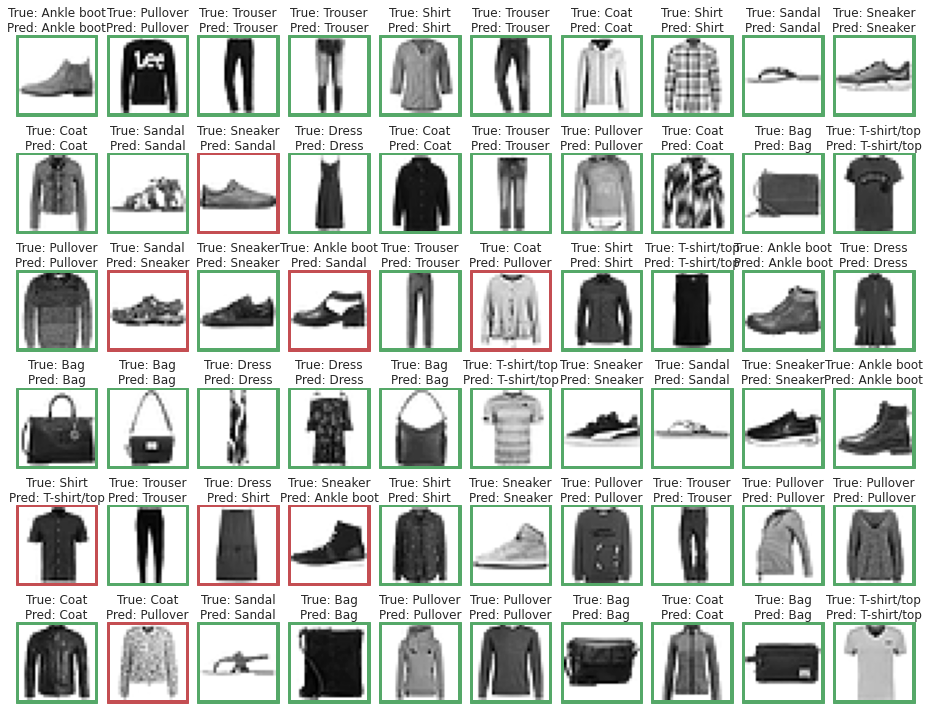

In [ ]:
y_train_val_pred = dt1_trained['y_train_val_pred']
print_samples(X_train_val_sc,6,10,labels_dict,y_train_val,y_train_val_pred)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# general function to print a confusion matrix
def print_confusion_matrix(y,y_pred,labels_dict):
  groud_truth = np.array([labels_dict[k] for k in y])
  predictions = np.array([labels_dict[k] for k in y_pred])
  classes = list(labels_dict.values())
  cm = confusion_matrix(groud_truth, predictions, labels=classes)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
  fig, ax = plt.subplots(figsize=(10,10))
  plt.grid(False)
  disp.plot(ax=ax)
  plt.show()

Confusion matrix for the Decision Tree classification.

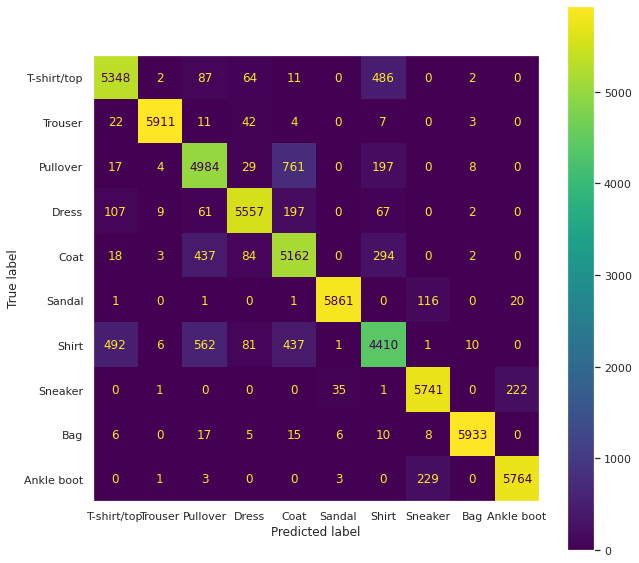

In [ ]:
print_confusion_matrix(y_train_val,y_train_val_pred,labels_dict)

Very frequently misclassified are "Pullover" and "Coat" samples. I visualize them: they are indeed very similar.

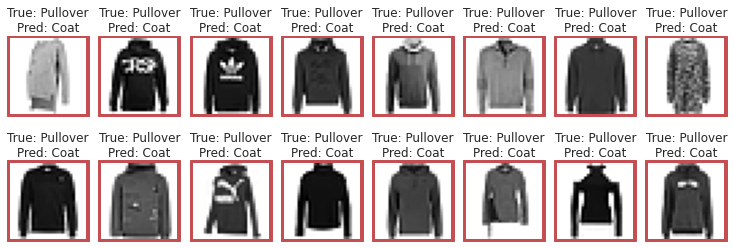

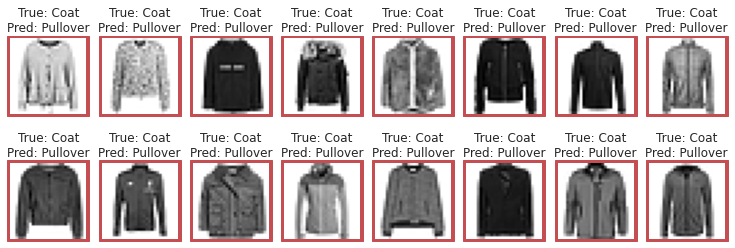

In [ ]:
# true: Pullover; predicted: Coat
indices = np.all([ (y_train_val==2), (y_train_val_pred==4) ], axis=0)
print_samples(X_train_val_sc[indices],2,8,labels_dict,y_train_val[indices],y_train_val_pred[indices])

# true: Coat; predicted: Pullover
indices = np.all([ (y_train_val==4), (y_train_val_pred==2) ], axis=0)
print_samples(X_train_val_sc[indices],2,8,labels_dict,y_train_val[indices],y_train_val_pred[indices])

## Neural network

General function to train a Neural Network with a given amount of hidden layers and units per (hidden) layer. Early stopping with patience = 5 is used for all the models. 

In [ ]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.python.framework.random_seed import set_random_seed
from keras.callbacks import EarlyStopping


def NN_trainer(X,y,hidden_layers,units_per_layer,n_batch_size=16,n_epochs=1000,augmentation_layer=None):

  # get input size
  input_size = X.shape[1]
  n_classes = y.shape[1]
    
  # early stopping
  es = EarlyStopping(monitor='val_loss',
                   mode='min', 
                   patience = 5, 
                   verbose=0)

  np.random.seed(123)
  set_random_seed(2)

  # build the model
  model = Sequential()

  # augmentation layer
  if augmentation_layer is not None:
    X = X.reshape((X.shape[0],28,28,1))
    model.add(augmentation_layer)
    model.add(Flatten())
  else:
    model.add(Dense(input_dim = input_size, units=input_size , activation='relu')) #input layer

  # add hidden layers
  for i in range(hidden_layers):
    model.add(Dense(units = units_per_layer, activation = 'relu'))
  model.add(Dense(n_classes, activation='softmax')) #output layer

  # Configure the model and start training
  model.compile(loss='categorical_crossentropy', #loss metric
      optimizer='sgd',  #optimizer
      metrics=['accuracy']) #displayed metric

  # Fit
  history = model.fit(X, y, epochs=n_epochs, batch_size=n_batch_size, verbose=0, validation_split=0.25, callbacks=[es])
  
  return model, history

In [ ]:
def plot_history(history):
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

Turn labels into categorical shape since the softmax layer requires it.

In [ ]:
y_train_val_cat = to_categorical(y_train_val, 10)
y_test_cat = to_categorical(y_test, 10)

Example of neural network built with the `NN_trainer` function. I visualize its architecture and plot accuracy and loss curves.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 784)               615440    
                                                                 
 dense_1 (Dense)             (None, 500)               392500    
                                                                 
 dense_2 (Dense)             (None, 500)               250500    
                                                                 
 dense_3 (Dense)             (None, 500)               250500    
                                                                 
 dense_4 (Dense)             (None, 500)               250500    
                                                                 
 dense_5 (Dense)             (None, 10)                5010      
                                                                 
Total params: 1,764,450
Trainable params: 1,764,450
Non-

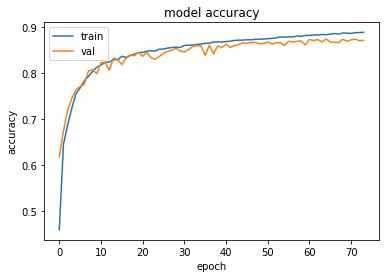

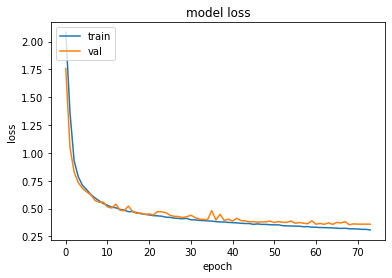

In [ ]:
# 4 hidden layers, 500 units per layer, batch size = 500
model0, h0 = NN_trainer(X_train_val_sc,y_train_val_cat,hidden_layers=4,units_per_layer=500,n_batch_size=500)

# architecture
print(model0.summary())

# accuracy and loss plot
plot_history(h0)

Function to perform grid search over a grid of parameters on a Neural Network.

In [ ]:
import operator

def grid_search_NN(grid_params,X,y,data_augmentation=None):
  accumulator = []
  # for every value of hidden layers
  for i in grid_params['hidden_layers']:
    # for every value of units per layer
    for j in grid_params['units_per_layer']:
      # for every value of batch size
      for k in grid_params['batch_size']:
        # train the NN with NN_trainer
        model, history = NN_trainer(X,y,hidden_layers=i,units_per_layer=j,n_batch_size=k,augmentation_layer=data_augmentation)
        accumulator.append([
             model,
             i,
             j,
             k,
             history.history['accuracy'][-1],
             history.history['val_accuracy'][-1]
        ])
        print("Trained model with",i,"hidden layers and",j,"neurons per layer",k,"batch_size")
  # sort by validation accuracy
  accumulator.sort(key=operator.itemgetter(5), reverse=True)
  # create a data frame table to print it nicely
  results = pd.DataFrame(accumulator)
  results = results.drop([0],axis=1)
  results.rename(columns={1: 'hidden_layers', 2: 'units_per_layer',3:'batch_size', 4:'train_accuracy', 5:'val_accuracy'}, inplace=True)
  display(HTML(results.to_html()))
  return accumulator[0][0]

In [ ]:
NN_grid_params = {
    'hidden_layers': [1,2,3],
    'units_per_layer': [50,100,150,200],
    'batch_size': [20,200,500]
}

NN_model = grid_search_NN(NN_grid_params,X_train_val_sc,y_train_val_cat)

Trained model with 1 hidden layers and 50 neurons per layer 20 batch_size
Trained model with 1 hidden layers and 50 neurons per layer 200 batch_size
Trained model with 1 hidden layers and 50 neurons per layer 500 batch_size
Trained model with 1 hidden layers and 100 neurons per layer 20 batch_size
Trained model with 1 hidden layers and 100 neurons per layer 200 batch_size
Trained model with 1 hidden layers and 100 neurons per layer 500 batch_size
Trained model with 1 hidden layers and 150 neurons per layer 20 batch_size
Trained model with 1 hidden layers and 150 neurons per layer 200 batch_size
Trained model with 1 hidden layers and 150 neurons per layer 500 batch_size
Trained model with 1 hidden layers and 200 neurons per layer 20 batch_size
Trained model with 1 hidden layers and 200 neurons per layer 200 batch_size
Trained model with 1 hidden layers and 200 neurons per layer 500 batch_size
Trained model with 2 hidden layers and 50 neurons per layer 20 batch_size
Trained model with 2 

,hidden_layers,units_per_layer,batch_size,train_accuracy,val_accuracy
0,2,100,20,0.935578,0.890667
1,3,150,20,0.922711,0.889600
2,1,200,20,0.931689,0.889533
3,2,150,20,0.936178,0.889333
4,1,50,20,0.928689,0.888933
5,2,50,20,0.916978,0.888333
6,2,200,20,0.920222,0.888267
7,1,150,20,0.930689,0.887867
8,3,100,20,0.922711,0.887867
9,1,100,20,0.928000,0.887333


### Hog-trasformation

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from skimage.feature import hog
from sklearn.pipeline import Pipeline
import skimage


class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(4, 4),
                 cells_per_block=(4, 4), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])


class Make2D(BaseEstimator, TransformerMixin):
    """
    Flat an image from 3D to 2D
    """
 
    def __init__(self,x_dimention,y_dimention):
        self.x_dimention = x_dimention
        self.y_dimention = y_dimention
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array(X).reshape((len(X),self.x_dimention,self.y_dimention))       


How images is affected by hog trasformation on different levels of pixel per cells and cells per block.

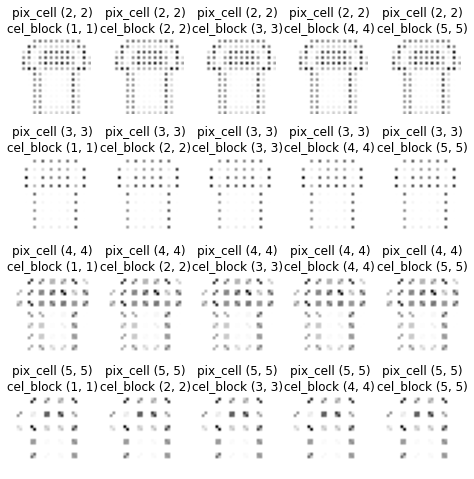

In [ ]:
hog_grid = {
    'pixels_per_cell' : [(2,2),(3,3),(4,4),(5,5)],
    'cells_per_block' : [(1,1),(2,2),(3,3),(4,4),(5,5)]
}

hog_images = []
titles = []
for i in hog_grid['pixels_per_cell']:
  for j in hog_grid['cells_per_block']:
    _, X_hog_image = hog(X_train_val[1].reshape(28,28),
                                    orientations=10,
                                    pixels_per_cell=i,
                                    cells_per_block=j,
                                    block_norm='L2-Hys',
                                    visualize=True)
    title = "pix_cell " + str(i) + "\ncel_block " + str(j)
    titles.append(title)
    hog_images.append(X_hog_image)



print_samples(np.array(hog_images).reshape(20,784),4,5,titles=titles)

I choose (2,2) pixel per cells as it seems to preserve and identify many details of the original image.

In [ ]:
# build a pipeline that first turns flattened images to 2d
# and then performs hog trasformation
preprocessing = Pipeline([
    ('make2D', Make2D(28,28)),
    ('hogTransformer', HogTransformer(pixels_per_cell=(2, 2),
                                      cells_per_block=(1, 1)))
])


In [ ]:
# apply HOG trasformation to both training and test data
X_train_val_hog = preprocessing.fit_transform(X_train_val)
X_test_hog = preprocessing.fit_transform(X_test)

Grid search for NN on HOG transformed images.

In [ ]:
NN1_grid_params = {
    'hidden_layers': [1,2],
    'units_per_layer': [100,200],
    'batch_size': [20]
}

NN1_model = grid_search_NN(NN1_grid_params,X_train_val_hog,y_train_val_cat)

Trained model with 1 hidden layers and 100 neurons per layer 20 batch_size
Trained model with 1 hidden layers and 200 neurons per layer 20 batch_size
Trained model with 2 hidden layers and 100 neurons per layer 20 batch_size
Trained model with 2 hidden layers and 200 neurons per layer 20 batch_size


,hidden_layers,units_per_layer,batch_size,train_accuracy,val_accuracy
0,1,100,20,0.961311,0.883800
1,1,200,20,0.962044,0.883000
2,2,100,20,0.981022,0.882467
3,2,200,20,0.985644,0.880600


### Data augmentation

Randomly flip images directly on the input layer thanks to [API provided by Tensorflow](https://www.tensorflow.org/tutorials/images/data_augmentation). 

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal")
])

Grid search on NN with augmented data.

In [ ]:
NN2_model = grid_search_NN(NN1_grid_params,X_train_val_sc,y_train_val_cat,data_augmentation=data_augmentation)

Trained model with 1 hidden layers and 100 neurons per layer 20 batch_size
Trained model with 1 hidden layers and 200 neurons per layer 20 batch_size
Trained model with 2 hidden layers and 100 neurons per layer 20 batch_size
Trained model with 2 hidden layers and 200 neurons per layer 20 batch_size


,hidden_layers,units_per_layer,batch_size,train_accuracy,val_accuracy
0,2,100,20,0.918000,0.887267
1,1,200,20,0.911822,0.883400
2,2,200,20,0.930289,0.880533
3,1,100,20,0.906644,0.880467


### Convolutional Neural Network

I build a Convolutional Neural Network: a powerful model frequently used for image recognition.

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout
  
# early stopping
es = EarlyStopping(monitor='val_loss',
                 mode='min', 
                 patience = 5, 
                 verbose=1)
np.random.seed(123)
set_random_seed(2)

# build the model
cnn = Sequential()
# convolutional layer with 60 3x3 filters
cnn.add(Conv2D(60,(3,3),activation='relu', input_shape=(28,28,1)))
# maxpooling layer
cnn.add(MaxPooling2D(pool_size=(2, 2)))
# flatten for a fully connected layer of 200 neurons
cnn.add(Flatten())
cnn.add(Dense(200,activation='relu'))
cnn.add(Dense(10,activation='softmax'))

# Configure the model and start training
cnn.compile(loss='categorical_crossentropy', #loss metric
    optimizer='sgd',  #optimizer
    metrics=['accuracy']) #displayed metric
    
# Fit
history_cnn = cnn.fit(X_train_val_sc.reshape(60000,28,28,1), 
                      y_train_val_cat, epochs=1000, 
                      verbose=1, validation_split=0.25, callbacks=[es])

Epoch 1/1000
1407/1407 [==============================] - 12s 8ms/step - loss: 0.7458 - accuracy: 0.7420 - val_loss: 0.5704 - val_accuracy: 0.7941
Epoch 2/1000
1407/1407 [==============================] - 11s 8ms/step - loss: 0.5055 - accuracy: 0.8185 - val_loss: 0.5052 - val_accuracy: 0.8124
Epoch 3/1000
1407/1407 [==============================] - 16s 11ms/step - loss: 0.4482 - accuracy: 0.8424 - val_loss: 0.4600 - val_accuracy: 0.8347
Epoch 4/1000
1407/1407 [==============================] - 15s 11ms/step - loss: 0.4138 - accuracy: 0.8536 - val_loss: 0.4039 - val_accuracy: 0.8533
Epoch 5/1000
1407/1407 [==============================] - 16s 11ms/step - loss: 0.3888 - accuracy: 0.8619 - val_loss: 0.3948 - val_accuracy: 0.8592
Epoch 6/1000
1407/1407 [==============================] - 11s 8ms/step - loss: 0.3665 - accuracy: 0.8690 - val_loss: 0.4201 - val_accuracy: 0.8489
Epoch 7/1000
1407/1407 [==============================] - 12s 8ms/step - loss: 0.3491 - accuracy: 0.8758 - val_loss

## Results

In [9]:
from sklearn.metrics import accuracy_score

# general function to test models on "X_test" dataset and "y_test" labels
def model_test(model,X_test,y_test):
  y_test_pred = model.predict(X_test)
  # if the labels are one-hot encoded
  if len(y_test.shape) == 2:
    accuracy = accuracy_score(y_test.argmax(axis=1), y_test_pred.argmax(axis=1))
  else:
    accuracy = accuracy_score(y_test, y_test_pred)
  return accuracy,y_test_pred

### Validation scores

According to the validation scores, the best model is the Convolutional Neural Network. I therefore would choose this model to be deployed for a classification task on the Fashion-MNIST dataset.

In [ ]:
models_names = ["Perceptron","DecisionTree","LogisticRegression","KNeighbors","RandomForest","SVC","NNVanilla","NN_hog","NN_augmented","CNN"]
valid_scores = [0.811617,0.816567,0.846800,0.854950,0.881083,0.889517,0.890667, 0.883800,0.887267,0.913000]

valid_results = []
for i,name in enumerate(models_names):
  valid_results.append([name,valid_scores[i]])

valid_results.sort(key=operator.itemgetter(1), reverse=True)
valid_results = pd.DataFrame(valid_results)
valid_results.rename(columns={0: 'model', 1: 'valid_accuracy'}, inplace=True)
display(HTML(valid_results.to_html()))

,model,valid_accuracy
0,CNN,0.913000
1,NNVanilla,0.890667
2,SVC,0.889517
3,NN_augmented,0.887267
4,NN_hog,0.883800
5,RandomForest,0.881083
6,KNeighbors,0.854950
7,LogisticRegression,0.846800
8,DecisionTree,0.816567
9,Perceptron,0.811617


### Test scores

The validation scores are confirmed by the test scores. The models perfom in the same way, so the choice of CNN resulted to be right.

In [ ]:
trained_models = [pc1_trained['model'],
                  dt1_trained['model'],
                  lr1_trained['model'],
                  knn1_trained['model'],
                  rf1_trained['model'],
                  svc1_trained['model'],
                  NN_model,
                  NN1_model,
                  NN2_model,
                  cnn]

test_results = []
for i,model in enumerate(trained_models):
  # needs hog data also for the test set
  if model == NN1_model:
    accuracy, _ = model_test(model,X_test_hog,y_test_cat)
  # needs categorical data as label
  elif model == NN_model or model == NN2_model:
    accuracy, _ = model_test(model,X_test_sc,y_test_cat)
  # needs reshaped 2d images as input
  elif model == cnn:
    accuracy, _ = model_test(model,X_test_sc.reshape(10000,28,28,1),y_test_cat)
  else:
    accuracy, _ = model_test(model,X_test_sc,y_test)
  test_results.append([models_names[i],accuracy])

test_results.sort(key=operator.itemgetter(1), reverse=True)
test_results = pd.DataFrame(test_results)
test_results.rename(columns={0: 'model', 1: 'test_accuracy'}, inplace=True)
display(HTML(test_results.to_html()))

,model,test_accuracy
0,CNN,0.9077
1,NNVanilla,0.8838
2,SVC,0.8828
3,NN_augmented,0.8771
4,NN_hog,0.8759
5,RandomForest,0.8723
6,KNeighbors,0.8544
7,LogisticRegression,0.8389
8,DecisionTree,0.8131
9,Perceptron,0.8063
